In [25]:
# In[1]: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings

In [26]:
# Configuration settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [27]:
FILE_PATH = '/content/dataset.csv'
TARGET_COLUMN = 'price'

In [28]:
# In[2]: Load Data
try:
    data = pd.read_csv(FILE_PATH)
    print(f"Data loaded successfully. Shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: File not found at '{FILE_PATH}'.")
    data = None

Data loaded successfully. Shape: (1002, 17)


In [29]:
# In[3]: Initial Cleaning
if data is not None:
    # Convert price to numeric (handling non-numeric strings if any)
    data['price'] = pd.to_numeric(data['price'], errors='coerce')
    # Convert mileage to numeric (assuming it's given in raw number form)
    data['mileage'] = pd.to_numeric(data['mileage'], errors='coerce')

    # Drop rows where price or year is missing, as these are critical
    data.dropna(subset=[TARGET_COLUMN, 'year'], inplace=True)

    # Calculate Age
    data['car_age'] = 2025 - data['year'] # Assuming analysis year is 2025
    data.drop('year', axis=1, inplace=True)

    print("Price, Year, and Age columns processed.")


Price, Year, and Age columns processed.


In [30]:
# In[4]: Cleaning Cylinders and Engine
if data is not None:
    # Ensure cylinders is numeric. If it's a string like '6', convert it.
    data['cylinders'] = pd.to_numeric(data['cylinders'], errors='coerce')

    # Basic feature engineering from 'engine' column (e.g., looking for 'Turbo' or displacement might be possible but complex)
    # For simplicity, we just clean up the 'cylinders' column

    # Drop raw text columns not used in modeling
    data.drop(['name', 'description', 'engine', 'trim'], axis=1, inplace=True)
    print("Cylinders and text features processed/dropped.")


Cylinders and text features processed/dropped.


In [31]:
# In[5]: Imputing Remaining NaNs
if data is not None:
    # Impute numerical features using the median
    num_cols = ['mileage', 'cylinders']
    for col in num_cols:
        data[col].fillna(data[col].median(), inplace=True)

    # Impute categorical features using the mode
    cat_cols = data.select_dtypes(include='object').columns
    for col in cat_cols:
        data[col].fillna(data[col].mode()[0], inplace=True)

    print(f"Total missing values remaining: {data.isnull().sum().sum()}")

Total missing values remaining: 7


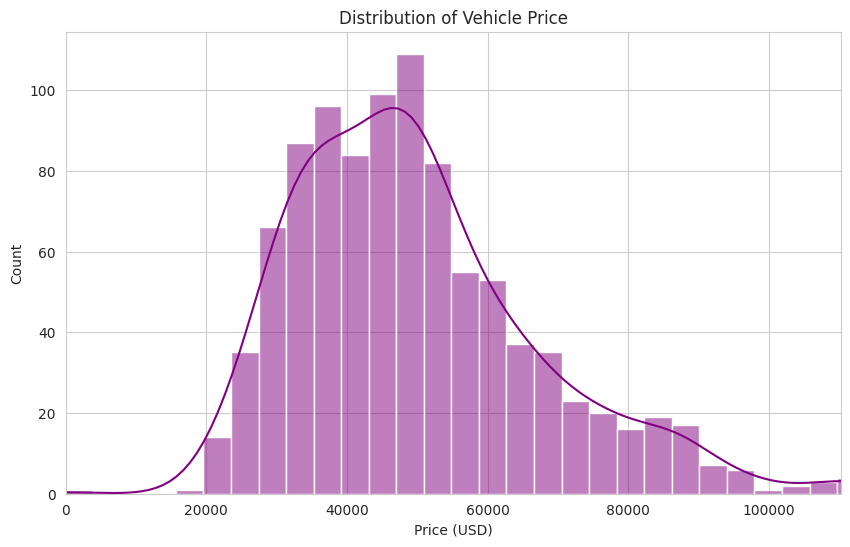

Mean Price: $50,202.99


In [32]:
# In[6]: Price Distribution
if data is not None:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[TARGET_COLUMN], bins=50, kde=True, color='purple')
    plt.title('Distribution of Vehicle Price')
    plt.xlabel('Price (USD)')
    plt.ylabel('Count')
    plt.xlim(0, data[TARGET_COLUMN].quantile(0.99)) # Capping x-axis for better visualization
    plt.show()

    print(f"Mean Price: ${data[TARGET_COLUMN].mean():,.2f}")

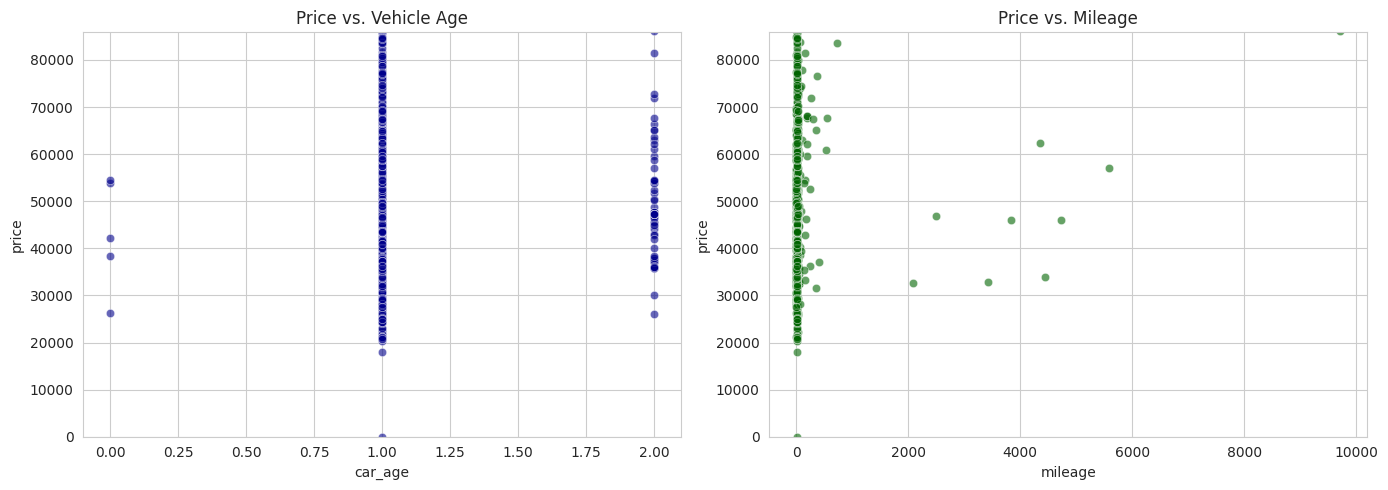

In [33]:
# In[7]: Price vs. Age and Mileage
if data is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Price vs. Car Age
    sns.scatterplot(x='car_age', y=TARGET_COLUMN, data=data, ax=axes[0], alpha=0.6, color='darkblue')
    axes[0].set_title('Price vs. Vehicle Age')
    axes[0].set_ylim(0, data[TARGET_COLUMN].quantile(0.95))

    # Price vs. Mileage
    sns.scatterplot(x='mileage', y=TARGET_COLUMN, data=data, ax=axes[1], alpha=0.6, color='darkgreen')
    axes[1].set_title('Price vs. Mileage')
    axes[1].set_ylim(0, data[TARGET_COLUMN].quantile(0.95))

    plt.tight_layout()
    plt.show()

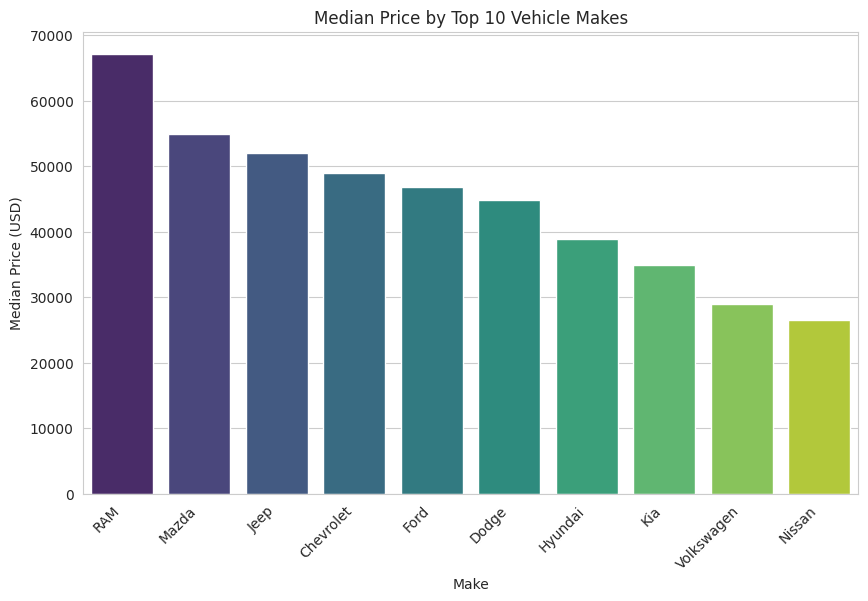

In [34]:
# In[8]: Price vs. Top 10 Makes
if data is not None:
    top_10_makes = data['make'].value_counts().nlargest(10).index
    make_prices = data[data['make'].isin(top_10_makes)].groupby('make')[TARGET_COLUMN].median().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=make_prices.index, y=make_prices.values, palette='viridis')
    plt.title('Median Price by Top 10 Vehicle Makes')
    plt.xlabel('Make')
    plt.ylabel('Median Price (USD)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

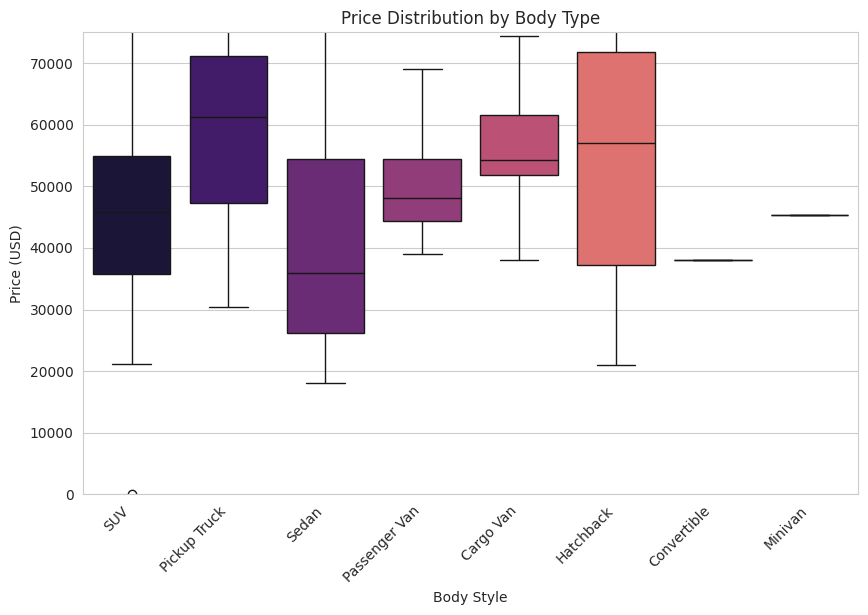

In [35]:
# In[9]: Price vs. Body Type
if data is not None:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='body', y=TARGET_COLUMN, data=data, palette='magma')
    plt.title('Price Distribution by Body Type')
    plt.xlabel('Body Style')
    plt.ylabel('Price (USD)')
    plt.ylim(0, data[TARGET_COLUMN].quantile(0.90))
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [36]:
# In[10]: Feature Separation
if data is not None:
    X = data.drop(TARGET_COLUMN, axis=1)
    y = data[TARGET_COLUMN]

    numerical_cols = ['cylinders', 'mileage', 'car_age']
    categorical_cols = X.select_dtypes(include='object').columns

    print(f"Categorical features to encode: {list(categorical_cols)}")

Categorical features to encode: ['make', 'model', 'fuel', 'transmission', 'body', 'exterior_color', 'interior_color', 'drivetrain']


In [37]:
# In[11]: One-Hot Encoding
if data is not None:
    # Use one-hot encoding only for categorical features with reasonable cardinality
    # For 'make', 'exterior_color', etc., limit to top N categories to prevent explosion

    X_encoded = X.copy()

    for col in ['make', 'fuel', 'transmission', 'body', 'drivetrain']:
        if col in X_encoded.columns:
            # Keep only the top 10 categories, lump the rest into 'Other'
            top_categories = X_encoded[col].value_counts().nlargest(10).index
            X_encoded[col] = np.where(X_encoded[col].isin(top_categories), X_encoded[col], 'Other')

    X_encoded = pd.get_dummies(X_encoded, columns=categorical_cols, drop_first=True)

    # Sanitize column names for LightGBM
    X_encoded.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_encoded.columns]

    print(f"Features after encoding. Shape: {X_encoded.shape}")

Features after encoding. Shape: (979, 540)


In [39]:
# In[12]: Scaling Numerical Data
if data is not None:
    # Impute any remaining NaNs introduced by one-hot encoding
    for col in X_encoded.columns:
      if X_encoded[col].isnull().any().item():
        if X_encoded[col].dtype in ['float64', 'int64']:
          X_encoded[col].fillna(X_encoded[col].median(), inplace=True)
        else:
          X_encoded[col].fillna(X_encoded[col].mode()[0], inplace=True)


    scaler = StandardScaler()
    X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
    print("Numerical features scaled.")
    print(X_encoded.head(2))

ValueError: can only convert an array of size 1 to a Python scalar

In [45]:
# In[13]: Splitting Data
if data is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42
    )

    # Sanitize column names for LightGBM after splitting
    import re
    X_train.columns = ["".join(re.findall(r'\w+', str(x))) for x in X_train.columns]
    X_test.columns = ["".join(re.findall(r'\w+', str(x))) for x in X_test.columns]

    # Impute missing values after splitting
    for col in X_train.columns:
        # Check if there are any nulls in the column
        if X_train[col].isnull().any() is True:
            if X_train[col].dtype in ['float64', 'int64']:
                median_val = X_train[col].median()
                X_train[col].fillna(median_val, inplace=True)
                X_test[col].fillna(median_val, inplace=True)
            else:
                mode_val = X_train[col].mode()[0]
                X_train[col].fillna(mode_val, inplace=True)
                X_test[col].fillna(mode_val, inplace=True)

    print(f"Training data size: {X_train.shape[0]} samples.")
    print(f"Testing data size: {X_test.shape[0]} samples.")

AttributeError: 'numpy.bool' object has no attribute 'bool'

In [ ]:
# In[14]: Define Models
if data is not None:
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0, random_state=42),
        'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
        'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
        'LightGBM Regressor': lgb.LGBMRegressor(random_state=42, n_estimators=100, verbose=-1)
    }
    results = {}
    print("6 Regression models defined.")

In [ ]:
# In[15]: Training Loop
if data is not None:
    print("\n--- Model Training and Evaluation ---")

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Ensure predictions are non-negative
        y_pred = np.maximum(0, y_pred)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}

        print(f"| {name:<20} | R2: {r2:.4f} | MAE: ${mae:,.0f} | RMSE: ${rmse:,.0f} |")

    performance_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)


In [ ]:
# In[15]: Training Loop
if data is not None:
    print("\n--- Model Training and Evaluation ---")

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Ensure predictions are non-negative
        y_pred = np.maximum(0, y_pred)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}

        print(f"| {name:<20} | R2: {r2:.4f} | MAE: ${mae:,.0f} | RMSE: ${rmse:,.0f} |")

    performance_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)

In [ ]:
# In[16]: Performance Table
if data is not None:
    print("\n--- Final Performance Summary (Sorted by R-squared) ---")
    print(performance_df)

In [ ]:
# In[17]: R2 and MAE Comparison Chart
if data is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # R-squared Plot (Higher is better)
    sns.barplot(x=performance_df.index, y='R2', data=performance_df, ax=axes[0], palette='crest')
    axes[0].set_title('Model R-squared Comparison (Goodness of Fit)')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('R-squared Score')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylim(0, 1)

    # MAE Plot (Lower is better)
    sns.barplot(x=performance_df.index, y='MAE', data=performance_df, ax=axes[1], palette='flare')
    axes[1].set_title('Model Mean Absolute Error (MAE) Comparison')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Mean Absolute Error (USD)')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
# In[18]: Best Model Residual Plot
if data is not None:
    best_model_name = performance_df.index[0]
    best_model = models[best_model_name]

    y_pred_best = best_model.predict(X_test)
    y_pred_best = np.maximum(0, y_pred_best)

    residuals = y_test - y_pred_best

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.6, color='darkred')
    plt.axhline(y=0, color='blue', linestyle='--')
    plt.title(f'Residual Plot for {best_model_name}')
    plt.xlabel('Predicted Price (USD)')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.ylim(residuals.quantile(0.01), residuals.quantile(0.99)) # Capping y-axis for clarity
    plt.show()

    print(f"\nConclusion: The best model is the {best_model_name}, with an R-squared of {performance_df.iloc[0]['R2']:.4f} and a median error (MAE) of approximately ${performance_df.iloc[0]['MAE']:,.0f}.")
    print("The residual plot shows the distribution of errors, ideally clustered around zero.")
